<a href="https://colab.research.google.com/github/Aelhanchi/torch_vr/blob/master/examples/CIFAR10_optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/Aelhanchi/torch_vr.git

In [0]:
import copy
import matplotlib.pyplot as plt

import torch
import torchvision

import os
os.chdir('./torch_vr')
import torch_vr
os.chdir('./examples')
from helpers import optimize

In [0]:
# uses GPU tensors by default
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [3]:
# Loads the CIFAR10 training dataset
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, 
                                   transform=torchvision.transforms.ToTensor)
X_train = torch.from_numpy(cifar10_train.data).to('cuda')/255.0
X_train.transpose_(3,2).transpose_(2,1)
y_train = torch.tensor(cifar10_train.targets).to('cuda')

# Loads the CIFAR10 test dataset
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, 
                                   transform=torchvision.transforms.ToTensor)
X_test = torch.from_numpy(cifar10_test.data).to('cuda')/255.0
X_test.transpose_(3,2).transpose_(2,1)
y_test = torch.tensor(cifar10_test.targets).to('cuda')

# flatten the images
X_train_flattened = X_train.flatten(1)
X_test_flattened = X_test.flatten(1)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# defines the loss
loss_func = torch.nn.NLLLoss(reduction='sum')

# defines helper functions
def accuracy(outputs, y):
  N = y.shape[0]
  predictions = torch.argmax(outputs, dim=1)
  return 100 * ((predictions == y).sum().float()/N)

# Softmax regression

In [0]:
# sets the seed for reproducibility
torch.manual_seed(0)

# defines the layers
layers = list()
layers.append(torch.nn.Linear(32*32*3, 9, bias=True))

# define the activations
activations = list()
def log_softmax(input):
  return torch.nn.functional.log_softmax(torch.cat([input, torch.ones_like(input[:, 0:1])], dim=1), dim=1)
activations.append(log_softmax)

# initializes the model
model = torch_vr.Sequential(layers, activations)

# caches the starting point
start = copy.deepcopy(model.state_dict())

In [14]:
# parameters of optimization
epochs = 100
batch_size = 128
step_size = 1e-07
momentum = 0.9

# SGD
torch.manual_seed(10)
SGD = optimize(X_train_flattened, y_train, X_test_flattened, y_test, 
               model, loss_func, accuracy, start, 
               step_size, epochs, 
               stochastic=True, batch_size=batch_size)

# SAGA
torch.manual_seed(10)
SAGA = optimize(X_train_flattened, y_train, X_test_flattened, y_test, 
                model, loss_func, accuracy, start, 
                step_size, epochs, 
                stochastic=True, batch_size=batch_size, var_reduce='SAGA')

# ASGD
torch.manual_seed(10)
ASGD = optimize(X_train_flattened, y_train, X_test_flattened, y_test, 
                model, loss_func, accuracy, start, 
                step_size, epochs, 
                accelerated=True, momentum=momentum,
                stochastic=True, batch_size=batch_size)

# ASAGA
torch.manual_seed(10)
ASAGA = optimize(X_train_flattened, y_train, X_test_flattened, y_test, 
                 model, loss_func, accuracy, start, 
                 step_size, epochs, 
                 accelerated=True, momentum=momentum,
                 stochastic=True, batch_size=batch_size, var_reduce='SAGA')

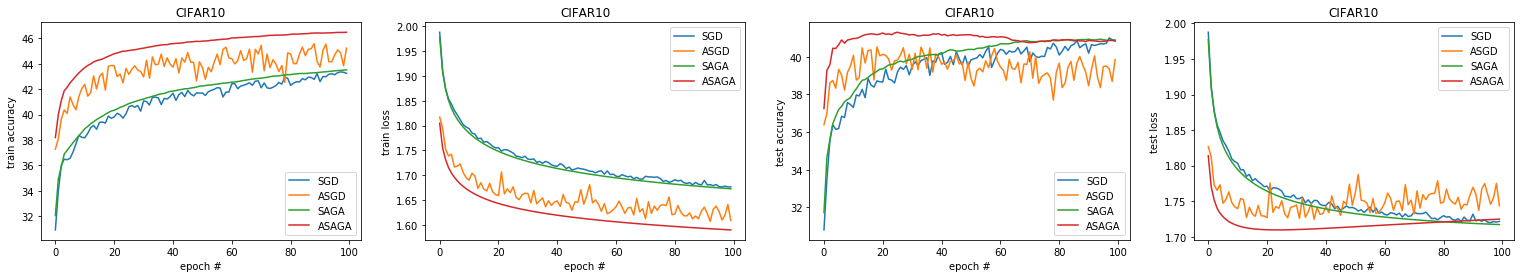

In [15]:
# plots the progress of each of SGD, SAGA, and SAG
fig, axes = plt.subplots(1, 4, sharey=False, figsize=(6.6*4,4))

axes[0].plot(SGD[0], label='SGD')
axes[0].plot(ASGD[0], label='ASGD')
axes[0].plot(SAGA[0], label='SAGA')
axes[0].plot(ASAGA[0], label='ASAGA')
axes[0].set_xlabel('epoch #')
axes[0].set_ylabel('train accuracy')
axes[0].set_title('CIFAR10')
axes[0].legend(loc="lower right");

axes[1].plot(SGD[1], label='SGD')
axes[1].plot(ASGD[1], label='ASGD')
axes[1].plot(SAGA[1], label='SAGA')
axes[1].plot(ASAGA[1], label='ASAGA')
axes[1].set_xlabel('epoch #')
axes[1].set_ylabel('train loss')
axes[1].set_title('CIFAR10')
axes[1].legend(loc="upper right");


axes[2].plot(SGD[2], label='SGD')
axes[2].plot(ASGD[2], label='ASGD')
axes[2].plot(SAGA[2], label='SAGA')
axes[2].plot(ASAGA[2], label='ASAGA')
axes[2].set_xlabel('epoch #')
axes[2].set_ylabel('test accuracy')
axes[2].set_title('CIFAR10')
axes[2].legend(loc="lower right");

axes[3].plot(SGD[3], label='SGD')
axes[3].plot(ASGD[3], label='ASGD')
axes[3].plot(SAGA[3], label='SAGA')
axes[3].plot(ASAGA[3], label='ASAGA')
axes[3].set_xlabel('epoch #')
axes[3].set_ylabel('test loss')
axes[3].set_title('CIFAR10')
axes[3].legend(loc="upper right");

plt.savefig('softmax_regression_cifar10.png')

# Convolutional neural network

In [0]:
# sets the seed for reproducibility
torch.manual_seed(100)

# defines the layers
layers = list()
layers.append(torch.nn.Conv2d(3, 16, (3,3), padding=1, bias=True))
layers.append(torch.nn.Conv2d(16, 16, (3,3), padding=1, bias=True))
layers.append(torch.nn.Conv2d(16, 16, (3,3), padding=1, stride=2, bias=True))

layers.append(torch.nn.Conv2d(16, 8, (3,3), padding=1, bias=True))
layers.append(torch.nn.Conv2d(8, 8, (3,3), padding=1, bias=True))
layers.append(torch.nn.Conv2d(8, 8, (3,3), padding=1, stride=2, bias=True))

layers.append(torch.nn.Linear(8*8*8, 9, bias=True))

# defines the activations
activations = list()
activations.append(torch.nn.functional.relu_)
activations.append(torch.nn.functional.relu_)
activations.append(torch.nn.functional.relu_)

activations.append(torch.nn.functional.relu_)
activations.append(torch.nn.functional.relu_)
def relu_flatten(input):
  return torch.nn.functional.relu(input.flatten(1))
activations.append(relu_flatten)

def log_softmax(input):
  return torch.nn.functional.log_softmax(torch.cat([input, torch.ones_like(input[:, 0:1])], dim=1), dim=1)
activations.append(log_softmax)

# initializes the model
model = torch_vr.Sequential(layers, activations)

# caches the starting point
start = copy.deepcopy(model.state_dict())

In [7]:
# gets close enough to the optimum for the variance reduction effect to be
# significant
batch_size = 128
import numpy as np
from tqdm import tqdm_notebook as tqdm
opt = torch.optim.Adam(model.parameters())
opt.zero_grad()
for i in tqdm(range(10000)):
  indices = np.random.choice(X_train.shape[0], batch_size, replace=False)
  loss = loss_func(model(X_train[indices]), y_train[indices])
  loss.backward()
  for p in model.parameters():
    p.grad *= X_train.shape[0]/len(indices)
  opt.step()
  opt.zero_grad()

start = copy.deepcopy(model.state_dict())


tensor(65.3520)


In [11]:
# parameters of optimization
step_size = 1e-08
momentum = 0.9
epochs = 100
batch_size = 128

# SGD
torch.manual_seed(10)
SGD = optimize(X_train, y_train, X_test, y_test, 
               model, loss_func, accuracy, start, 
               step_size, epochs, 
               stochastic=True, batch_size=batch_size)

# SAGA
torch.manual_seed(10)
SAGA = optimize(X_train, y_train, X_test, y_test, 
                model, loss_func, accuracy, start, 
                step_size, epochs, 
                stochastic=True, batch_size=batch_size, var_reduce='SAGA')

# ASGD
torch.manual_seed(10)
ASGD = optimize(X_train, y_train, X_test, y_test, 
                model, loss_func, accuracy, start, 
                step_size, epochs, 
                accelerated=True, momentum=momentum,
                stochastic=True, batch_size=batch_size)

# ASAGA
torch.manual_seed(10)
ASAGA = optimize(X_train, y_train, X_test, y_test, 
                 model, loss_func, accuracy, start, 
                 step_size, epochs, 
                 accelerated=True, momentum=momentum,
                 stochastic=True, batch_size=batch_size, var_reduce='SAGA')

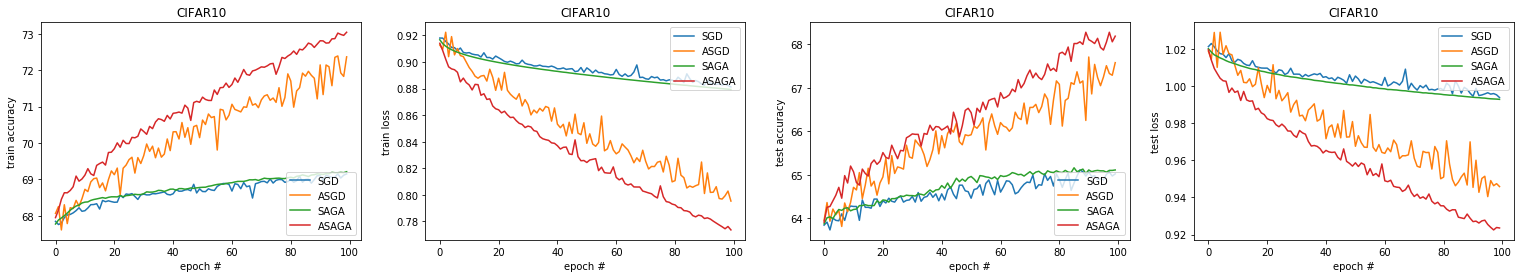

In [12]:
# plots the progress of each of SGD, SAGA, and SAG
fig, axes = plt.subplots(1, 4, sharey=False, figsize=(6.6*4,4))

axes[0].plot(SGD[0], label='SGD')
axes[0].plot(ASGD[0], label='ASGD')
axes[0].plot(SAGA[0], label='SAGA')
axes[0].plot(ASAGA[0], label='ASAGA')
axes[0].set_xlabel('epoch #')
axes[0].set_ylabel('train accuracy')
axes[0].set_title('CIFAR10')
axes[0].legend(loc="lower right");

axes[1].plot(SGD[1], label='SGD')
axes[1].plot(ASGD[1], label='ASGD')
axes[1].plot(SAGA[1], label='SAGA')
axes[1].plot(ASAGA[1], label='ASAGA')
axes[1].set_xlabel('epoch #')
axes[1].set_ylabel('train loss')
axes[1].set_title('CIFAR10')
axes[1].legend(loc="upper right");

axes[2].plot(SGD[2], label='SGD')
axes[2].plot(ASGD[2], label='ASGD')
axes[2].plot(SAGA[2], label='SAGA')
axes[2].plot(ASAGA[2], label='ASAGA')
axes[2].set_xlabel('epoch #')
axes[2].set_ylabel('test accuracy')
axes[2].set_title('CIFAR10')
axes[2].legend(loc="lower right");

axes[3].plot(SGD[3], label='SGD')
axes[3].plot(ASGD[3], label='ASGD')
axes[3].plot(SAGA[3], label='SAGA')
axes[3].plot(ASAGA[3], label='ASAGA')
axes[3].set_xlabel('epoch #')
axes[3].set_ylabel('test loss')
axes[3].set_title('CIFAR10')
axes[3].legend(loc="upper right");

plt.savefig('cnn_cifar10.png')